In [1]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
from sklearn.linear_model import QuantileRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor
import os
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import warnings
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
from sklearn.exceptions import ConvergenceWarning
from sklearn import preprocessing as skp
from sklearn import model_selection as sms
from sklearn import feature_selection as skf
from sklearn import linear_model as slm
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util as util
import nibabel as nib
import os
import pickle
from torch import nn
import gc
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,5)
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0]//2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()
    

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index-1) % volume.shape[0] 
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index+1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [3]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
visualize = 0
# Load data
nrows = 512
ncols = 512
nslices = 352
segs = []
qsms = []
laros = []
voxel_sizes = []
trackers = []
q_directory = '/home/ali/RadDBS-QSM/data/nii/new_qsm/'
q_directory = os.listdir(q_directory)
q_directory = sorted(q_directory)
s_directory = '/home/ali/RadDBS-QSM/data/nii/new_seg/'
s_directory = os.listdir(s_directory)
s_directory = sorted(s_directory)

n_cases = 115

In [4]:
cv_names = {'CORNELL ID',
            ' OFF (pre-dbs updrs)',
            ' ON (pre-dbs updrs)',
            ' OFF meds ON stim 6mo',
            'Age',
            'Sex',
            'Ethnicity',
            'Race',
            'Disease Duration (year)',
            'Physician',
            ' pre op levadopa equivalent dose (mg)',
            ' Location',
            ' Target',
            ' Test medication status'}


# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/dbs_03292024.csv'
motor_df = util.filter_data(file_dir,cv_names,True)
# Find cases with all required scores
cv_dict = util.filter_cases(motor_df,cv_names)
subs = cv_dict['CORNELL ID']
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/new/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/new/phi/'
roi_path = '/home/ali/RadDBS-QSM/data/xlxs/new_segs.csv'
n_rois = 6
all_rois = False
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,all_rois)
print(np.unique(R_all))
ids = np.asarray(ID_all).astype(int)

# Use cases from only 1 rater
phys = cv_dict['Physician']
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(ids).astype(int),np.asarray(cv_dict['CORNELL ID']).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
# Exclude GPi
c_cases_idx[ids == 36] = 0
c_cases_idx[ids == 53] = 0
c_cases_idx[ids == 98] = 0
c_cases_idx[ids == 108] = 0
print(np.sum(c_cases_idx))
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
print(len(s_cases_idx))
        
X_all_c = X_all[c_cases_idx,2:6,:]
#X_all_c = (np.load('X2h_sr.npy').T).reshape((31,6381))
# print('Applying combat')
K_all_c = K_all[c_cases_idx,2:6,:]
R_all_c = R_all[c_cases_idx,2:6,:]
# Re-index the scored subjects with respect to complete cases

per_change = ((cv_dict[' OFF (pre-dbs updrs)']-cv_dict[' OFF meds ON stim 6mo'])/cv_dict[' OFF (pre-dbs updrs)'])[s_cases_idx]
pre_imp = ((cv_dict[' OFF (pre-dbs updrs)']-cv_dict[' ON (pre-dbs updrs)'])/cv_dict[' OFF (pre-dbs updrs)'])[s_cases_idx]
pre_updrs = cv_dict[' OFF (pre-dbs updrs)'][s_cases_idx]
dd = cv_dict['Disease Duration (year)'][s_cases_idx]
ledd = cv_dict[' pre op levadopa equivalent dose (mg)'][s_cases_idx]
tmed = cv_dict[' Test medication status'][s_cases_idx]
phys = cv_dict['Physician'][s_cases_idx]
age = cv_dict['Age'][s_cases_idx]
loc = cv_dict[' Location'][s_cases_idx]
sex = cv_dict['Sex'][s_cases_idx]
rce = cv_dict['Race'][s_cases_idx]
eth = cv_dict['Ethnicity'][s_cases_idx]
tgt = cv_dict[' Target'][s_cases_idx]
subsc = subs[s_cases_idx]
# Reshape keys and ROIs
if all_rois == True:
    K_all_cu = np.empty((K_all_c.shape[0],K_all_c.shape[1],K_all_c.shape[2]+1),dtype=object)
    K_all_cu[:,:,:-1] = K_all_c
    K_all_cu[:,:,-1] = 'pre_updrs'
    K_all_cu[:,:,-1] = 'disease_duration'
    K_all_cu[:,:,-1] = 'pre op levadopa equivalent dose (mg)'
    K_all_cu[:,:,-1] = ' Test medication status'
    K_all_cu[:,:,-1] = 'Physician'
    K_all_cu[:,:,-1] = 'Age'
    K_all_cu[:,:,-1] = 'Location'
    K_all_cu[:,:,-1] = 'Sex'
    K_all_cu[:,:,-1] = 'Race'
    K_all_cu[:,:,-1] = 'Ethnicity'
    
    K = K_all_cu.reshape((K_all_cu.shape[0],K_all_cu.shape[1]*K_all_cu.shape[2]))[0]
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))
else:
    K_all_c = K_all_c.reshape((K_all_c.shape[0],K_all_c.shape[1]*K_all_c.shape[2]))[0]
    R_all_c = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))

print(np.unique(R_all_c))

Keeping CORNELL ID
Keeping Age
Keeping Sex
Keeping Ethnicity
Keeping Race
Keeping Disease Duration (year)
Keeping Physician
Keeping  OFF (pre-dbs updrs)
Keeping  ON (pre-dbs updrs)
Keeping  pre op levadopa equivalent dose (mg)
Keeping  Location
Keeping  Target
Keeping  Test medication status
Keeping  OFF meds ON stim 6mo
{' OFF meds ON stim 6mo', 'Race', 'CORNELL ID', 'Ethnicity', ' Test medication status', ' Location', 'Physician', ' pre op levadopa equivalent dose (mg)', 'Disease Duration (year)', ' Target', ' ON (pre-dbs updrs)', ' OFF (pre-dbs updrs)', 'Age', 'Sex'}
Allocated arrays
Created feature matrix
Created ROI matrix
Created feature label matrix
['Left red nucleus' 'Left substantia nigra pars retic'
 'Left subthalamic nucleus' 'Right red nucleus'
 'Right substantia nigra pars reti' 'Right subthalamic nucleus']
61
69
['Left substantia nigra pars retic' 'Left subthalamic nucleus'
 'Right substantia nigra pars reti' 'Right subthalamic nucleus']


In [5]:
np.round(per_change,2).T

array([0.71, 0.5 , 0.67, 0.77, 0.97, 0.74, 0.71, 0.78, 0.85, 0.57, 0.74,
       0.48, 0.71, 0.81, 0.82, 0.67, 0.88, 0.19, 0.85, 0.78, 0.3 , 0.89,
       0.08, 0.52, 0.74, 0.81, 0.53, 0.91, 0.66, 0.53, 0.8 , 0.89, 0.48,
       0.76, 0.26, 0.81, 0.97, 0.56, 0.65, 0.66, 0.52, 0.84, 0.15, 0.5 ,
       0.09, 0.3 , 0.46, 0.64, 0.96, 0.82, 0.71, 0.78, 0.69, 0.62, 0.6 ,
       0.61, 0.63, 0.94, 0.61, 0.45, 0.62])

In [6]:
# motor_df.insert(0, "Improvement", np.round((motor_df[' OFF (pre-dbs updrs)'].values.astype(float)-motor_df[' OFF meds ON stim 6mo'].values.astype(float))/motor_df[' OFF (pre-dbs updrs)'].values.astype(float),2), True)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
#     display(motor_df[s_cases_idx])

In [7]:
n_cases = len(per_change)
results_ls_aug = np.zeros_like(per_change)
results_lgr_aug = np.zeros_like(per_change)
results_lgrp_aug = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
r = 1

In [9]:
retrain = 1
if retrain == 1:

  Js = []
  aug = False
  err_var = np.zeros_like(per_change)
  rerror = np.zeros_like(per_change)
  kappa = []
  K_nz = []
  E_nz = []
  c = 0

  K_all_c = np.append(K_all_c,['pre updrs']*5)
  for j in np.arange(len(subsc)):
      test_id = subsc[j]
      test_index = subsc == test_id
      train_index = subsc != test_id
      X_train = X_all_c[train_index,:,:]
      X_test = X_all_c[test_index,:,:]
      y_train = per_change[train_index]
      y_test = per_change[test_index]

      y_cat = y_train <= 0.3
      idy = np.where(y_cat==1)
      # Cross validation
                                            
      X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_updrs,None,None,dd,ledd,phys,None,None,None,None,False,False,False)
      cvn = 10
      cv_scores = np.zeros((cvn,1))
      cv_lgr_scores = np.zeros((cvn,1))
      rs = 1
      rcfs = 1000
      (mu, sigma) = stats.norm.fit(y_train)
      kappa = stats.skew(y_train)
      print('Label distribution of:',mu,sigma,kappa)
      for jj in np.arange(2,cvn):
        # Resample to avoid stratification errors
        while np.sum(y_cat) < 2*(cvn-1):
          np.random.seed(rs)
          idyr = np.random.choice(np.asarray(idy).ravel())
          X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
          y_train = np.append(y_train,y_train[idyr])
          y_cat = y_train <= 0.3
          rs = rs+1
          print('Resampled to size',y_train.shape)
        if aug == True:
          # y_train_n = y_train+(1.96*sigma)*np.random.normal(0,1,1)
          z_train = (y_train-np.mean(y_train))/(np.std(y_train)/np.sqrt(len(y_train)))
          z_train_ns = z_train+1.96*np.std(z_train)*np.random.normal(0,1,1)
          y_train_n = z_train_ns*((np.std(y_train)/np.sqrt(len(y_train))))+np.mean(y_train)
          y_train = np.hstack((y_train,y_train_n))
          y_cat = y_train <= 0.3
          X0_ss0 = np.vstack((X0_ss0,X0_ss0))
      
      for jj in np.arange(2,cvn):
        skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
        skf_gen = skf_g.split(X0_ss0,y_cat)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None)
        with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
          # Feature selection
          warnings.filterwarnings("ignore", category=ConvergenceWarning)
          sel = skf.SelectKBest(skf.f_regression,k=1500)#skf.RFECV(lasso,step=rcfs,cv=skf_gen,n_jobs=1)
          # Stratifies classifiers automatically
          #sel_lr = skf.SelectKBest(r_regression,k=1500)#skf.RFECV(lgr,step=rcfs,cv=jj,n_jobs=1)
          X0_ss = sel.fit_transform(X0_ss0,y_train)
          # X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
          est_ls = lasso.fit(X0_ss,y_train)
          # est_lgr = lgr.fit(X0_ssl,y_cat)
          cv_scores[jj] = est_ls.score(X0_ss,y_train)
          # cv_lgr_scores[jj] = est_lgr.score(X0_ssl,y_cat)
          print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
          
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
        best_cv = np.argmax(cv_scores)
        best_cv_lgr = np.argmax(cv_lgr_scores)

        # Break any ties
        if np.sum(cv_scores == best_cv) > 1:
          cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
          cv_lgr_scores_tb = np.zeros((np.sum(cv_scores == best_cv_lgr),1))
          for jjj in (cv_scores == cv_scores[best_cv]):
            if jjj > 0:
              print('Breaking tie')
              skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
              skf_gen = skf_g.split(X0_ss0,y_cat) 
              X0_ss = sel.fit_transform(X0_ss0,y_train)
              X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
              est_ls = lasso.fit(X0_ss,y_train)
              # est_lgr = lgr.fit(X0_ssl,y_cat)
              lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
              # lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None)
              est_ls = lasso.fit(X0_ss,y_train)
              # est_lgr = lgr.fit(X0_ssl,y_cat)
              cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
              # cv_lgr_scores_tb[jj] = est_lgr.score(sel_lr.fit_transform(X0_ss0,y_cat),y_cat)
          best_cv = np.argmax(cv_scores_tb)
          best_cv_lgr = np.argmax(cv_lgr_scores_tb)
        
        # Fit whole dataset with optimal cv
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None)
        sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
        sel_lr = skf.RFECV(lgr,step=rcfs,cv=best_cv)
        X0_ss = sel.fit_transform(X0_ss0,y_train)
        X_test_ss = sel.transform(X_test_ss0)
        # X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
        # X_test_ssl = sel_lr.transform(X_test_ss0)
        #K_ss = sel.transform(K_all_c.reshape(1,-1))

      # LASSO
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=best_cv,class_weight=None)
        est_ls = lasso.fit(X0_ss,y_train)
        # est_lgr = lgr.fit(X0_ssl,y_cat)
      # results_lgr_aug[c] = est_lgr.predict(X_test_ssl)
      # results_lgrp_aug[c] = est_lgr.predict_proba(X_test_ssl)[0][0]
      results_ls_aug[c] = est_ls.predict(X_test_ss)
      print('Lasso predicts',str(np.round(results_ls_aug[c],4)),'and logistic regression predicts',results_lgr_aug[c],
                'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv,'and',sum(y_cat),'minority cases')
      # K_nz.append(np.squeeze(K_ss)[est_ls.coef_>0])
      E_nz.append(est_ls.coef_[est_ls.coef_>0])
      c=c+1

  # np.save('results_ls_aug_d.npy',results_ls_aug)
  # np.save('results_lgr_aug_d.npy',results_lgr_aug)
  # np.save('results_lgrp_aug_d.npy',results_lgrp_aug)

else:
  print('Loading')
  # results_ls_aug = np.load('results_ls_aug_d.npy')
  # results_lgr_aug = np.load('results_lgr_aug_d.npy')
  #results_lgrp_aug = np.load('results_lgr_aug_d.npy')

  


Label distribution of: 0.6471560005431053 0.21564013096418103 -0.8589531666768364
Resampled to size (61,)
Resampled to size (62,)
Resampled to size (63,)
LassoCV score for 2 is [0.] from dataset of size (63, 1500)
LassoCV score for 3 is [0.99802228] from dataset of size (63, 1500)
LassoCV score for 4 is [0.99746438] from dataset of size (63, 1500)
Lasso predicts 0.6613 and logistic regression predicts 0.0 for case with 0.71 and selected CV 3 and 8 minority cases
Label distribution of: 0.6506175390046437 0.21491590549216863 -0.9102668435676828
Resampled to size (61,)
Resampled to size (62,)
Resampled to size (63,)
LassoCV score for 2 is [0.] from dataset of size (63, 1500)
LassoCV score for 3 is [0.94651081] from dataset of size (63, 1500)
LassoCV score for 4 is [0.99785839] from dataset of size (63, 1500)
Lasso predicts 0.6457 and logistic regression predicts 0.0 for case with 0.5 and selected CV 4 and 8 minority cases
Label distribution of: 0.6478397612268659 0.21576591836236428 -0.86

In [10]:
np.mean(X0_ss0)

-0.0007587615260552293

In [11]:
np.var(X0_ss[:,10])

1.0027553835288727

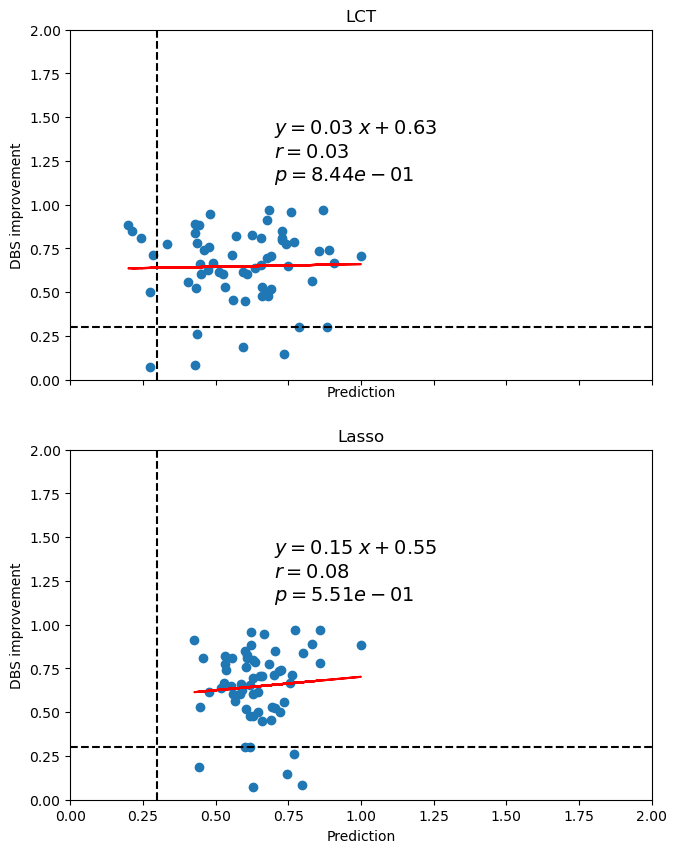

In [16]:
results_ls_aug[results_ls_aug>1]=1
util.eval_prediction(np.vstack((pre_imp,
                               results_ls_aug,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(15,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')

In [13]:
# Js = []
# aug = True
# err_var = np.zeros_like(per_change)
# rerror = np.zeros_like(per_change)
# kappa = []
# c = 0
# for j in np.arange(len(subsc)):
#     test_id = subsc[j]
#     test_index = subsc == test_id
#     train_index = subsc != test_id
#     X_train = X_all_c[train_index,:]
#     X_test = X_all_c[test_index,:]
#     y_train = per_change[train_index]
#     y_test = per_change[test_index]

#     y_cat = y_train <= 0.3
#     N = np.sum(y_cat)
#     idy = np.where(y_cat==1)
#     # Cross validation
                                          
#     X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
#                                                 X_train,train_index,X_test,
#                                                 test_index,pre_updrs,loc,tmed,dd,ledd,phys,eth,rce,sex,tgt,False,False,False)
#     # X0_ss0 = X_train
#     # X_test_ss0 = X_test

#     cvn = 10
#     cv_scores = np.zeros((cvn,1))
#     rs = 1
#     rcfs = 1000
#     (mu, sigma) = stats.norm.fit(y_train)
#     kappa = stats.skew(y_train)
#     print('Label distribution of:',mu,sigma,kappa)
#     np.random.seed(rs)
#     for jj in np.arange(2,cvn):
#       # Resample to avoid stratification errors
#       while np.sum(y_cat) < 2*N-1: #2*np.sum(y_cat)-1
#         np.random.seed(rs)
#         idyr = np.random.choice(np.asarray(idy).ravel())
#         X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
#         y_train = np.append(y_train,y_train[idyr])
#         y_cat = y_train <= 0.3
#         rs = rs+1
#         print('Resampled to size',y_train.shape)
#       if aug == True:
#         y_train_n = y_train+(sigma/mu)*np.random.normal(0,4*sigma,1)
#         y_train = np.hstack((y_train,y_train_n))
#         y_cat = y_train <= 0.3
#         X0_ss0 = np.vstack((X0_ss0,X0_ss0))

    
#     for jj in np.arange(2,cvn):
#       skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
#       skf_gen = skf_g.split(X0_ss0,y_cat)
#       lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
#       with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
#         # Feature selection
#         warnings.filterwarnings("ignore", category=ConvergenceWarning)
#         sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen)
#         X0_sst = sel.fit_transform(X0_ss0,y_train)
#         X0_ss = X0_sst
#         est_ls = lasso.fit(X0_ss,y_train)
#         cv_scores[jj] = est_ls.score(X0_ss,y_train)
#         print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
        
#     with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
#       best_cv = np.argmax(cv_scores)

#       # Break any ties
#       if np.sum(cv_scores == best_cv) > 1:
#         cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
#         for jjj in (cv_scores == cv_scores(best_cv)):
#           if jjj > 0:
#             skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
#             skf_gen = skf_g.split(X0_ss0,y_cat) 
#             X0_sst = sel.fit_transform(X0_ss0,y_train)
#             X0_ss = X0_sst
#             lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
#             est_ls = lasso.fit(X0_ss,y_train)
#             cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
#         best_cv = np.argmax(cv_scores_tb)
      
#       # Fit whole dataset with optimal cv
#       lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
#       sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
#       X0_sst = sel.fit_transform(X0_ss0,y_train)
#       X_test_sst = sel.transform(X_test_ss0)
#       X0_ss = X0_sst
#       X_test_ss = X_test_sst

#     # LASSO
#     with warnings.catch_warnings():
#       warnings.filterwarnings("ignore", category=ConvergenceWarning)
#       lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
#       est_ls = lasso.fit(X0_ss,y_train)
#     results_ls_aug[c] = est_ls.predict(X_test_ss)
#     print('Lasso predicts',str(np.round(results_ls_aug[c],4)),
#               'for case',subsc[j], 'with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv)
  
#     c=c+1

      

  


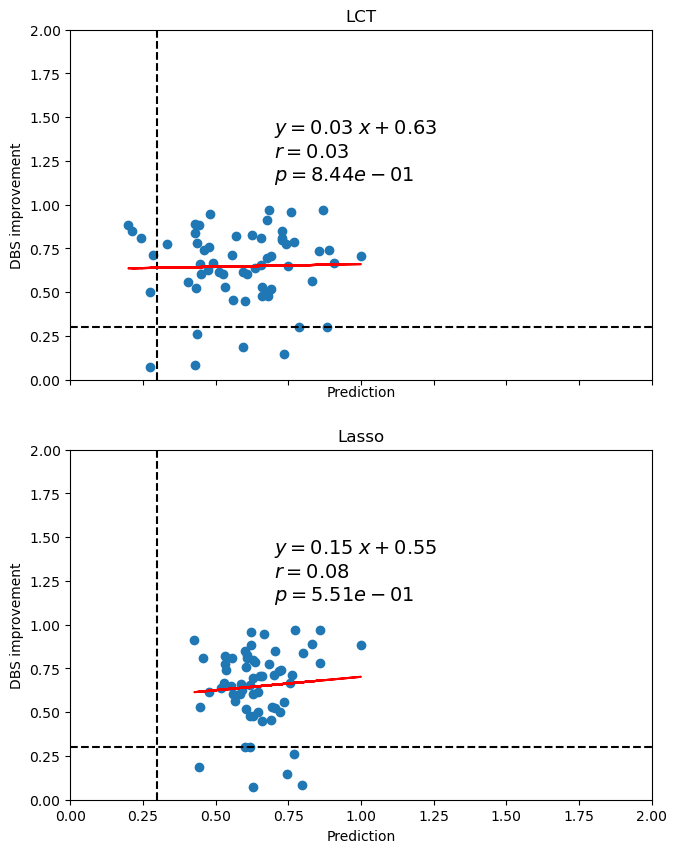

In [14]:
results_ls_aug[results_ls_aug>1]=1
util.eval_prediction(np.vstack((pre_imp,
                               results_ls_aug,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(15,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')

In [15]:
Js = []
aug = False
err_var = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
kappa = []
c = 0
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]

    y_cat = y_train <= 0.3
    idy = np.where(y_cat==1)
    # Cross validation
                                          
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_updrs,None,None,None,None,None,None,None,None,None,False,False,False)
    # X0_ss0 = X_train
    # X_test_ss0 = X_test

    cvn = 5
    cv_scores = np.zeros((cvn,1))
    rs = 1
    rcfs = 1000
    (mu, sigma) = stats.norm.fit(y_train)
    kappa = stats.skew(y_train)
    print('Label distribution of:',mu,sigma,kappa)
    np.random.seed(rs)
    # for jj in np.arange(2,cvn):
      # # Resample to avoid stratification errors
      # while np.sum(y_cat) < cvn: #2*np.sum(y_cat)-1
      #   np.random.seed(rs)
      #   idyr = np.random.choice(np.asarray(idy).ravel())
      #   X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
      #   y_train = np.append(y_train,y_train[idyr])
      #   y_cat = y_train <= 0.3
      #   rs = rs+1
      #   print('Resampled to size',y_train.shape)
      # if aug == True:
      #   y_train_n = y_train+(sigma/mu)*np.random.normal(0,4*sigma,1)
      #   y_train = np.hstack((y_train,y_train_n))
      #   y_cat = y_train <= 0.3
      #   X0_ss0 = np.vstack((X0_ss0,X0_ss0))

    
    for jj in np.arange(2,cvn):
      skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
      skf_gen = skf_g.split(X0_ss0,y_cat)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
      # with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
      #   # Feature selection
      #   warnings.filterwarnings("ignore", category=ConvergenceWarning)
      sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen,min_features_to_select=100)
      X0_sst = sel.fit_transform(X0_ss0,y_train)
      print(sel.score(X0_ss0,y_train))
      X0_ss = X0_sst
      est_ls = lasso.fit(X0_ss,y_train)
      cv_scores[jj] = est_ls.score(X0_ss,y_train)
      print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
        
    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
      best_cv = np.argmax(cv_scores)

      # # Break any ties
      # if np.sum(cv_scores == best_cv) > 1:
      #   cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
      #   for jjj in (cv_scores == cv_scores[best_cv]):
      #     if jjj > 0:
      #       skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
      #       skf_gen = skf_g.split(X0_ss0,y_cat) 
      #       X0_sst = sel.fit_transform(X0_ss0,y_train)
      #       X0_ss = X0_sst
      #       lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
      #       est_ls = lasso.fit(X0_ss,y_train)
      #       cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
      #   best_cv = np.argmax(cv_scores_tb)
      
      # Fit whole dataset with optimal cv
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
      sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
      X0_sst = sel.fit_transform(X0_ss0,y_train)
      X_test_sst = sel.transform(X_test_ss0)
      X0_ss = X0_sst
      X_test_ss = X_test_sst

    # LASSO
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
      est_ls = lasso.fit(X0_ss,y_train)
    results_ls_aug[c] = est_ls.predict(X_test_ss)
    print('Lasso predicts',str(np.round(results_ls_aug[c],4)),
              'for case',subsc[j], 'with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv)
  
    c=c+1

      

  


Label distribution of: 0.6471560005431053 0.21564013096418103 -0.8589531666768364
0.0
LassoCV score for 2 is [0.] from dataset of size (60, 100)
0.0
LassoCV score for 3 is [0.] from dataset of size (60, 100)
0.0
LassoCV score for 4 is [0.] from dataset of size (60, 5381)


ValueError: k-fold cross-validation requires at least one train/test split by setting n_splits=2 or more, got n_splits=0.

In [ ]:
jjj

In [ ]:

util.eval_prediction(np.vstack((pre_imp,
                               results_ls,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(15,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')

In [ ]:
pre_imp = np.repeat((np.asarray(pre_updrs_iii_off,dtype=float)-np.asarray(pre_updrs_iii_on,dtype=float))/np.asarray(pre_updrs_iii_off,dtype=float),r)
per_change = np.repeat(per_change,r)
plt.rcParams['figure.figsize'] = [20, 5]
fig,ax = plt.subplots(1,3,sharex=True,sharey=True)
#ax[0].scatter(pre_imp,per_change)
col = np.where(per_change <= 0.3,'orange','blue')
ax[0].scatter(pre_imp,per_change, c=col,linewidth=0)
lr = stats.linregress(pre_imp,per_change)
y_model = pre_imp*lr.slope+lr.intercept
ax[0].plot(pre_imp,y_model,color='r')
ax[0].text(0.6,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.3f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[0].transAxes,fontsize=16)  
ax[0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].set_title('LCT',fontsize=16)
ax[0].set_ylabel('True improvement',fontsize=16)

col = np.where(per_change <= 0.3,'orange','blue')
ax[1].scatter(results_ls,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls),per_change)
y_model = results_ls*lr.slope+lr.intercept
ax[1].plot(results_ls,y_model,color='r')
ax[1].text(0.55,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[1].transAxes,fontsize=16) 
ax[1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].set_title('Lasso',fontsize=16)
ax[1].set_xlabel('Prediction',fontsize=16)
col = np.where(per_change <= 0.3,'orange','blue')
ax[2].scatter(results_ls_aug,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls_aug),per_change)
y_model = results_ls_aug*lr.slope+lr.intercept
ax[2].plot(results_ls_aug,y_model,color='r')
ax[2].text(0.55,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[2].transAxes,fontsize=16) 
ax[2].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[2].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[2].set_title('Noise Compensated Lasso',fontsize=16)
plt.ylim([0,1.25])
plt.xlim([0,1.25])
plt.style.use('default')

In [ ]:
# np.save('results_ls_aug_msw.npy',results_ls_aug)

In [ ]:
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# best fit of data
(mu, sigma) = stats.norm.fit(per_change)

# the histogram of the data
# zn, zbins, zpatches = plt.hist(per_change, bins=16, density=True)

n, bins, patches = plt.hist(per_change, bins='auto', density=True)

# add a 'best fit' line
y = norm.pdf(zbins, mu, sigma)
l = plt.plot(zbins, y, 'r', linewidth=2)

#plot
plt.xlabel('y')
plt.ylabel('f(y)')
plt.title(r'$\mathrm{Label \ distribution}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)

plt.show()